## Imports

In [1]:
import sys
import time
import importlib
import sparse
import datetime
import pandas as pd
import numpy as np
import scipy.sparse
import matplotlib.pyplot as plt

import Utils.dbutils as dbutils
import Utils.data_utils as data_utils
import Generators.CohortGenerator as CohortGenerator
import Generators.FeatureGenerator as FeatureGenerator
import config
local_imports = (
    dbutils,
    data_utils,
    CohortGenerator,
    FeatureGenerator,
    config
)
for i in local_imports:
    i = importlib.reload(i)

## Cohort, Outcome and Feature Collection

### 1. Set up a connection to the OMOP CDM database

Parameters for connection to be specified in ./config.py

In [2]:
# database connection
username = config.PG_USERNAME
password = config.PG_PASSWORD
database_name = config.DB_NAME

config_path = 'postgresql://{username}:{password}@{database_name}'.format(
    username = username,
    password = password,
    database_name = database_name
)

# schemas 
schema_name = 'eol_all_prediction_times_test' # all created tables will be created using this schema

# caching
reset_schema = False # if true, rebuild all data from scratch

# set up database, reset schemas as needed
db = dbutils.Database(config_path, schema_name)
if reset_schema:
    db.execute(
        'drop schema if exists {} cascade'.format(schema_name)
    )
db.execute(
    'create schema if not exists {}'.format(schema_name)
)

Executed 1 SQLs


/home/justinl/miniconda3/lib/python3.7/site-packages/sqlalchemy/dialects/postgresql/base.py:3323: SAWarning: Skipped unsupported reflection of expression-based index idx__loc_source_value
  "expression-based index %s" % idx_name


### Build a Cohort for the End of Life Prediction Task

##### Create a Cohort Object that can be constructed as specified by SQL File & Params

We provide two different cohort queries that both include all positive samples:
- gen_EOL_cohort_all_prediction_times.sql: includes all positive samples and uniform negative samples (one per person)
- gen_EOL_cohort_matched_prediction_times.sql: includes all positive samples and matched positive and negative sample distributions

In [3]:
cohort_name = '__eol_cohort'

# cohort_script_path = config.SQL_PATH_COHORTS + '/gen_EOL_cohort_all_prediction_times.sql'
cohort_script_path = config.SQL_PATH_COHORTS + '/gen_EOL_cohort_matched_prediction_times.sql'

# cohort parameters  
params = {
          'cohort_table_name'     : cohort_name,
          'schema_name'           : schema_name,
          'gap'                   : '3 months',
          'outcome_window'        : '6 months',
          'eligibility_period'    : '1 year',       ## Required enrollement duration before prediction time
          'positive_pred_unif'    : 'true',         ## If 'true', then uniformly sample prediction times for positive samples
          'positive_pred_delta'   : '6 months',     ## ...otherwise, fixed interval.
          'dummy_date'            : '1900-01-01',   ## Can be arbitrary, but must be consistent with feature SQL scripts
          'max_prediction_date'   : '2017-01-01'    ## Only use prediction times up to this parameter   
         }

cohort = CohortGenerator.Cohort(
    schema_name=schema_name,
    cohort_table_name=cohort_name,
    cohort_generation_script=cohort_script_path,
    cohort_generation_kwargs=params,
    outcome_col_name='y'
)

##### Build Cohort

In [4]:
cohort.build(db, replace=True)

Regenerating Table (replace=True)
Regenerated Cohort in 698.2969369888306 seconds


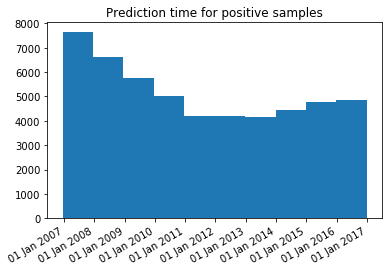

In [5]:
import matplotlib.dates as mdates
plt.hist(pd.to_datetime(cohort._cohort[cohort._cohort.y == 1].end_date))
plt.gca().xaxis.set_major_locator(mdates.YearLocator((1)))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%d %b %Y"))
plt.gcf().autofmt_xdate()
plt.title("Prediction time for positive samples")
plt.show()

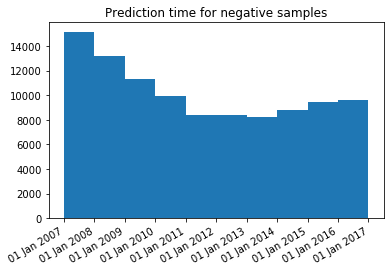

In [6]:
import matplotlib.dates as mdates
plt.hist(pd.to_datetime(cohort._cohort[cohort._cohort.y == 0].end_date))
plt.gca().xaxis.set_major_locator(mdates.YearLocator((1)))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%d %b %Y"))
plt.gcf().autofmt_xdate()
plt.title("Prediction time for negative samples")
plt.show()

### Get a Time Series of Features for Cohort Members

In [7]:
featureSet = FeatureGenerator.FeatureSet(db)
featureSet.add_default_features(
    ['drugs_relative','conditions_relative','procedures_relative','specialty_relative'],
    schema_name,
    cohort_name
)

In [8]:
%%time
# Build the Feature Set by executing SQL queries and reading into sparse matrices
cache_data_path = '/tmp/cache_data_eol_all_prediction_times_test'
featureSet.build(cohort, from_cached=False, cache_file=cache_data_path)

Data loaded to buffer in 3522.06 seconds
Got Unique Concepts and Timestamps in 111.92 seconds
Created Index Mappings in 0.04 seconds
142317
Generated Sparse Representation of Data in 323.52 seconds
CPU times: user 7min 34s, sys: 1min 30s, total: 9min 5s
Wall time: 1h 5min 57s


In [9]:
outcomes_filt, feature_matrix_3d_transpose, remap, good_feature_names = \
    FeatureGenerator.postprocess_feature_matrix(cohort, featureSet, training_end_date_col='dummy_date')

### Build a Model to Predict End of Life using this data

#### Transform Data to get a vector of counts over 1, 6, 12, 24 and infinity (represented by 10000 days) month windows for each Patient

In [10]:
%%time
feature_matrix_counts, feature_names = data_utils.window_data(
    window_lengths = [30, 180, 365, 730, 10000],
    feature_matrix = feature_matrix_3d_transpose,
    all_feature_names = good_feature_names,
    cohort = cohort,
    featureSet = featureSet,
    cohort_end_date_col = 'dummy_date'
)

CPU times: user 11min 48s, sys: 21.5 s, total: 12min 9s
Wall time: 12min 9s


In [11]:
feature_matrix_counts.T

<125351x168285 sparse matrix of type '<class 'numpy.float64'>'
	with 30010475 stored elements in Compressed Sparse Column format>

#### Set up a standard sklearn modelling pipeline

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, average_precision_score

def sparse_ufunc(f):
    def wrapper(*a, **k):
        X = a[0]
        if not scipy.sparse.isspmatrix(X):
            raise ValueError
        X2 = X.copy()
        X2.data = f(X2.data, *(a[1:]), **k)
        return X2
    return wrapper

@sparse_ufunc
def tr_func(X, kwarg=1):
    return np.clip(X, 0, kwarg)

func = FunctionTransformer(
    func=tr_func,
    accept_sparse=True,
    validate=True,
    kw_args={'kwarg': 1}
)

#### Instantiate, Train and Test Model

In [13]:
indices = range(len(outcomes_filt))
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(
    feature_matrix_counts.T, outcomes_filt, indices,
    test_size=0.33, random_state=1
)

VAL_SZ = 10000
vals = [10, 1, 0.1, 0.01, 0.001, 0.0001]
scores = []
best_score = -1
best_model = None
for C in vals:
    lr = LogisticRegression(
        class_weight='balanced', C=C,
        penalty='l1', fit_intercept=True,
        solver='liblinear', random_state=0,
        verbose=0, max_iter = 200, tol=1e-1
    )
    
    # The classifier will transform each data point using func, which here takes a count vector to a binary vector
    # Then, it will use logistic regression to classify the transformed data
    clf = Pipeline([
        ('func',func),
        ('lr', lr)
    ])

    clf.fit(X_train, y_train)
    score = roc_auc_score(y_test[:VAL_SZ], clf.predict_proba(X_test[:VAL_SZ, :])[:, 1])
    print("C: %.4f, validation AUC: %.3f" % (C, score))
    if score > best_score:
        best_score = score
        best_model = clf
pred = best_model.predict_proba(X_test[VAL_SZ:, :])[:, 1]
print('Model Test AUC: {0:.3f}'.format(roc_auc_score(y_test[VAL_SZ:], pred)))

C: 10.0000, validation AUC: 0.806
C: 1.0000, validation AUC: 0.837
C: 0.1000, validation AUC: 0.856
C: 0.0100, validation AUC: 0.837
C: 0.0010, validation AUC: 0.791
C: 0.0001, validation AUC: 0.500
Model Test AUC: 0.859


#### Evaluate Model : RoC and Precision-Recall Curves

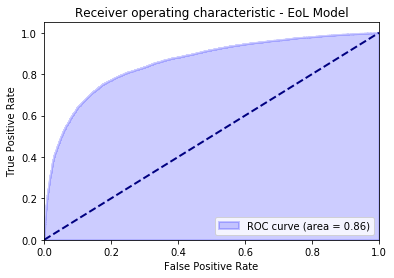

In [14]:
fpr, tpr, _ = roc_curve(y_test[VAL_SZ:], pred)
plt.figure()
lw = 2
plt.fill_between(fpr, tpr, color='b', alpha = 0.2,
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_score(y_test[VAL_SZ:], pred))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic - EoL Model')
plt.legend(loc="lower right")
plt.show()

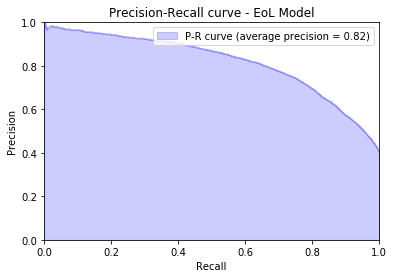

In [15]:
precision, recall, _ = precision_recall_curve(y_test[VAL_SZ:], pred)

from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test[VAL_SZ:], pred)

plt.figure()
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(
    recall, precision, alpha=0.2, color='b',
    label='P-R curve (average precision = %0.2f)' % average_precision
)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.legend(loc="upper right")
plt.title('Precision-Recall curve - EoL Model')
plt.show()

#### Evaluate Model : Extract Feature Weights

In [16]:
feature_weights = pd.DataFrame({
    'feature_name': feature_names,
    'feature_weight': list(best_model.get_params()['lr'].coef_[0])
}).sort_values(by='feature_weight')
pd.set_option('display.max_colwidth', -1)

/home/justinl/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """


In [17]:
feature_weights.tail(20)

,feature_name,feature_weight
107119,201519 - condition - Primary malignant neoplasm of liver - 730 days,0.386052
155265,40164968 - drug - Megestrol Acetate 40 MG Oral Tablet - 10000 days,0.393541
154254,377821 - condition - Neurological disorder with type 1 diabetes mellitus - 10000 days,0.397160
92214,"4166126 - condition - Localized swelling, mass and lump, trunk - 365 days",0.399113
107481,"2101925 - procedure - Debridement, subcutaneous tissue (includes epidermis and dermis, if performed); first 20 sq cm or less - 730 days",0.405335
64524,443961 - condition - Anemia of chronic renal failure - 180 days,0.413883
21715,40222796 - drug - Meclizine Hydrochloride 25 MG Oral Tablet - 30 days,0.426997
135346,134765 - condition - Cachexia - 10000 days,0.428241
87952,40164972 - drug - Megestrol Acetate 40 MG/ML Oral Suspension - 365 days,0.467445
120243,374028 - condition - Age related macular degeneration - 730 days,0.471251


In [18]:
feature_weights.head(20)

,feature_name,feature_weight
95813,434894 - condition - Acute posthemorrhagic anemia - 365 days,-0.531804
112512,2313972 - procedure - Physician or other qualified health care professional services for outpatient cardiac rehabilitation; with continuous ECG monitoring (per session) - 730 days,-0.525737
101012,1112892 - drug - Aspirin 325 MG Delayed Release Oral Tablet - 730 days,-0.523455
156814,40233236 - drug - 12 HR CHLORPHENIRAMINE POLISTIREX 1.6 MG/ML / HYDROCODONE POLISTIREX 2 MG/ML Extended Release Suspension [Tussionex] - 10000 days,-0.499959
41297,"2105103 - procedure - Arthroplasty, knee, condyle and plateau; medial AND lateral compartments with or without patella resurfacing (total knee arthroplasty) - 180 days",-0.498345
73824,"2101925 - procedure - Debridement, subcutaneous tissue (includes epidermis and dermis, if performed); first 20 sq cm or less - 365 days",-0.429131
129907,43560451 - drug - Albuterol 0.833 MG/ML / Ipratropium Bromide 0.167 MG/ML Inhalation Solution - 730 days,-0.425577
146608,"2514528 - procedure - Periodic comprehensive preventive medicine reevaluation and management of an individual including an age and gender appropriate history, examination, counseling/anticipatory guidance/risk factor reduction interventions, and the ordering of laboratory/diag - 10000 days",-0.395876
160873,42708405 - drug - ezetimibe 10 MG / Simvastatin 80 MG Oral Tablet [Vytorin] - 10000 days,-0.363241
127538,"42739102 - procedure - Dual energy x-ray absorptiometry (DEXA), bone density study, one or more sites; axial skeleton (eg, hips, pelvis, spine) - 730 days",-0.359102


In [19]:
for category in ['procedure', 'condition', 'drug', 'specialty']:
    print('Number of nonzero {} feature weights : {}'.format(
        category,
        sum(feature_weights.loc[
            [i for i,j in enumerate(feature_names) if '- ' + category + ' -' in j]
        ]['feature_weight'] != 0)
    ))

Number of nonzero procedure feature weights : 1105
Number of nonzero condition feature weights : 1607
Number of nonzero drug feature weights : 1067
Number of nonzero specialty feature weights : 86
